In [1]:
import json
import os
import sys

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ribs.archives import CVTArchive, SlidingBoundariesArchive
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.feature_extraction.text as sk_text
from sklearn.manifold import TSNE
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from archives import ConceptPCAArchive, ConceptsAndLengthArchive
from config import ArchiveGame
from ludii_datasets import _collect_games
from java_api import Concepts
from java_helpers import CONCEPT_DTYPES

In [3]:
# Load dataset used for the language model training / archive initialization
DATASET_NAME = "LudiiLMs/code-llama-13b-fitm-mask-heldout-1-epoch"
dataset_train = load_dataset(DATASET_NAME + '-base-data', split='train', token=os.environ['HF_TOKEN'])
dataset_val = load_dataset(DATASET_NAME + '-base-data', split='val', token=os.environ['HF_TOKEN'])

In [9]:
concept_extractor = Concepts()

In [10]:
concepts_per_train_game = []
for train_game in tqdm(dataset_train['base_game'], desc='Extracting concepts from training games'):
    concepts = concept_extractor.compile(train_game)
    concepts = [concept for idx, concept in enumerate(concepts) if CONCEPT_DTYPES[idx] == bool]
    concepts_per_train_game.append(concepts)

concepts_per_val_game = []
for val_game in tqdm(dataset_val['base_game'], desc='Extracting concepts from validation games'):
    concepts = concept_extractor.compile(val_game)
    concepts = [concept for idx, concept in enumerate(concepts) if CONCEPT_DTYPES[idx] == bool]
    concepts_per_val_game.append(concepts)

concepts_per_game = concepts_per_train_game + concepts_per_val_game
    

Extracting concepts from training games:   0%|          | 0/574 [00:00<?, ?it/s]

Extracting concepts from validation games: 100%|██████████| 14/14 [00:00<00:00, 17.53it/s]


Text(0.5, 1.0, 'Density plot of the first two principal components')

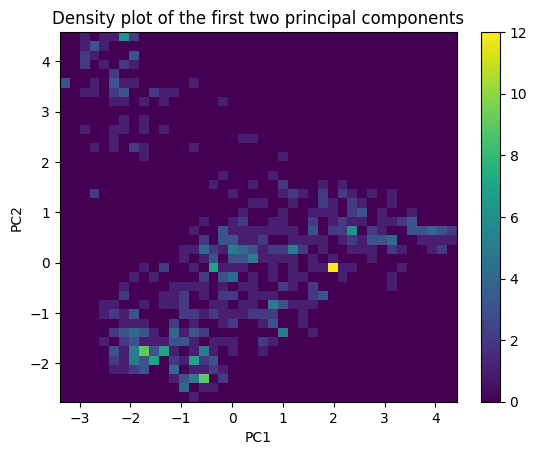

In [41]:
# Density plot of the first two principal components
pca = PCA(n_components=2)
pca.fit(concepts_per_game)
concepts_pca = pca.transform(concepts_per_game)

plt.figure()
plt.hist2d(concepts_pca[:, 0], concepts_pca[:, 1], bins=40, cmap='viridis')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Density plot of the first two principal components')

<Axes: ylabel='Density'>

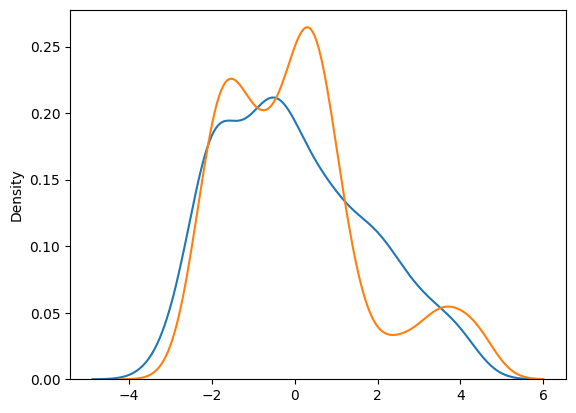

In [43]:
# Density plots of the first two dimensions
sns.kdeplot(concepts_pca[:, 0])
sns.kdeplot(concepts_pca[:, 1])

In [12]:
# Fit a PCA model and report explained variance
pca = PCA()
pca.fit(concepts_per_game)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

for i in [0, 1, 4, 9, 99]:
    print(f"Explained variance with {i+1} components: {explained_variance[i]}")

Explained variance with 1 components: 0.12764383755288633
Explained variance with 2 components: 0.2446349629700259
Explained variance with 5 components: 0.4381229832893549
Explained variance with 10 components: 0.5872188646008261
Explained variance with 100 components: 0.9687937674353821


# Experiments with Rectangular Archive

In [11]:
def get_unique_cells(transformed_concepts, boundaries_per_dim):
    unique_cells = set()
    for entry in transformed_concepts:
        cell = tuple([np.digitize(c, boundaries) for c, boundaries in zip(entry, boundaries_per_dim)])
        unique_cells.add(cell)
    return unique_cells

In [14]:
for dim in [2, 3]:
    for num_cells in [100, 500, 1100, 1500]:
        cells_per_dim = int(num_cells ** (1 / dim))

        pca = PCA(n_components=dim)
        pca.fit(concepts_per_game)

        transformed = pca.transform(concepts_per_game)
        transformed_val = pca.transform(concepts_per_val_game)
        print(f"\n===PCA with {dim} dimensions and ~{num_cells} cells ({cells_per_dim} per dim)===")

        boundaries_per_dim = []
        for i in range(dim):
            # boundaries = np.linspace(transformed[:, i].min(), transformed[:, i].max(), cells_per_dim)
            boundaries = np.percentile(transformed[:, i], np.linspace(0, 100, cells_per_dim))
            boundaries_per_dim.append(boundaries)

        archive_indices = get_unique_cells(transformed, boundaries_per_dim)
        archive_indices_val = get_unique_cells(transformed_val, boundaries_per_dim)


        print(f"Archive size: {len(transformed)} games (total) --> {len(archive_indices)} unique cells")
        print(f"Archive size: {len(transformed_val)} games (validation) --> {len(archive_indices_val)} unique cells")

        for i in boundaries_per_dim:
            print(list(i))

        break
    break



===PCA with 2 dimensions and ~100 cells (10 per dim)===
Archive size: 588 games (total) --> 64 unique cells
Archive size: 14 games (validation) --> 12 unique cells
[-3.391198502863103, -2.0977806868785867, -1.6432391205047499, -0.9808969209922879, -0.5033338472470043, 0.02092175190850446, 0.7021309904852309, 1.5196419636960643, 2.431709158982519, 4.4186200754502885]
[-2.7610502337654, -1.8717770474727837, -1.5103915517672024, -0.9619870097035561, -0.3407555508406298, 0.14128630144003815, 0.4611383507502491, 0.8110542303388261, 2.432284511689792, 4.576378955323499]


## Experiments with Sliding Boundary Archive

In [ ]:
for dim in [2, 3, 4, 5]:
    for num_cells in [100, 500, 1000, 1500]:
        cells_per_dim = int(num_cells ** (1 / dim))

        pca = PCA(n_components=dim)
        pca.fit(concepts_per_game)

        transformed = pca.transform(concepts_per_game)
        transformed_val = pca.transform(concepts_per_val_game)

        archive = SlidingBoundariesArchive(
            solution_dim=dim,
            dims=[cells_per_dim] * dim,
            
        )

# Test ConceptAndLengthArchive

In [4]:
archive = ConceptsAndLengthArchive(
    DATASET_NAME,
    pca_dims=2,
    cells_per_pca_dim=25,
    num_length_cells=4
)

In [5]:
print(archive.boundaries_per_dim)

[array([-3.39119862, -2.47481951, -2.22734536, -2.06899342, -1.90195458,
       -1.763923  , -1.58189328, -1.28451454, -1.04668534, -0.830265  ,
       -0.66675771, -0.51306357, -0.37899348, -0.15118341,  0.02488808,
        0.26762594,  0.47398283,  0.78082299,  1.01096886,  1.28162195,
        1.6934054 ,  1.93740675,  2.34945656,  2.84657229,  3.54399426,
        4.41862003]), array([-2.76105007, -2.25045581, -1.97099974, -1.84881743, -1.72520565,
       -1.61084915, -1.43887215, -1.27875185, -1.03969726, -0.8442979 ,
       -0.63960308, -0.36657373, -0.13802693, -0.03050169,  0.17168931,
        0.27333266,  0.37516955,  0.48068022,  0.61693288,  0.72009208,
        0.90904067,  1.29313657,  2.28091235,  3.35974428,  3.9217776 ,
        4.5763791 ])]


In [ ]:
[-3.391198502863103, -2.0977806868785867, -1.6432391205047499, -0.9808969209922879, -0.5033338472470043, 0.02092175190850446, 0.7021309904852309, 1.5196419636960643, 2.431709158982519, 4.4186200754502885]
[-2.7610502337654, -1.8717770474727837, -1.5103915517672024, -0.9619870097035561, -0.3407555508406298, 0.14128630144003815, 0.4611383507502491, 0.8110542303388261, 2.432284511689792, 4.576378955323499]

In [9]:
unique_cells = set()
for g in tqdm(dataset_val['base_game'], desc='Extracting unique cells'):
    game = ArchiveGame(g, 0, {}, [], 0, "", 0)
    cell = archive._get_cell(game)
    unique_cells.add(cell)

print(f"Unique cells in training set: {len(unique_cells)}")

Extracting unique cells:   0%|          | 0/14 [00:00<?, ?it/s]

Extracting unique cells: 100%|██████████| 14/14 [00:01<00:00,  9.67it/s]

Unique cells in training set: 14
